# WikiRecentPhase2

## Streams processing + windowing
[WikiRecentPhase1](imgAna_1.jupyter-py36.ipynb) illustrated accessing a Wikipedia continuously with Streams job Using
a view to look at the live data and building a UI to fetch view Wikipedia activity. This notebook brings
Streams to bear on more of the processing. 


## Overview 
**About the sample** 

The appliction recieves Wikipedia updates as events via SSE, processes events that were edited by humans. 
The events are staged into windows in order that aggregations can be done over time and events counts.
Wikipedia accepts content in variety of language, before doing the time based aggregation the contents
declared language is mapped. 

Since the Streams application runs on the server independent of an open Juypter session it analyzes data
over larger windows or time and events. This enables monitoring the events over hours and days to dervive
insights into how Wikipedia is modified over time. 



<a name="setup"></a>
# Setup
### Add credentials for the IBM Streams service

#### ICPD setup

With the cell below selected, click the "Connect to instance" button in the toolbar to insert the credentials for the service.

<a target="blank" href="https://developer.ibm.com/streamsdev/wp-content/uploads/sites/15/2019/02/connect_icp4d.gif">See an example</a>.

#### Cloud setup

To use Streams instance running in the cloud setup a [credential.py](setup_credential.ipynb)

## Imports 

In [1]:
# Install components
!pip install sseclient
!pip install --user --upgrade streamsx

Requirement already up-to-date: streamsx in /Users/siegenth/.local/lib/python3.6/site-packages (1.13.5)


In [2]:
# Setup 
import pandas as pd

from IPython.core.debugger import set_trace
from IPython.display import display, clear_output

from statistics import mean
from collections import deque
from collections import Counter

import datetime
import json

import matplotlib.pyplot as plt
import ipywidgets as widgets
%matplotlib inline

from sseclient import SSEClient as EventSource

from ipywidgets import Button, HBox, VBox, Layout
from ipywidgets import Button, HBox, VBox, Layout

from streamsx.topology.topology import *
import streamsx.rest as rest
from streamsx.topology import context


## Support functions for Jupyter

In [3]:
def catchInterrupt(func):
    """decorator : when interupt occurs the display is lost if you don't catch it
       TODO * <view>.stop_data_fetch()  # stop
       
    ."""
    def catch_interrupt(*args, **kwargs):
        try: 
            func(*args, **kwargs)
        except (KeyboardInterrupt): pass
    return catch_interrupt

#
# Support for locating/rendering views.
def display_view_stop(eventView, period=2):
    """Wrapper for streamsx.rest_primitives.View.display() to have button. """
    button =  widgets.Button(description="Stop Updating")
    display(button)
    eventView.display(period=period) 
    def on_button_clicked(b):
        eventView.stop_data_fetch()
        b.description = "Stopped"
    button.on_click(on_button_clicked)

def view_events(views):
    """
    Build interface to display a list of views and 
    display view when selected from list.
     
    """
    view_names = [view.name for view in views]
    nameView = dict(zip(view_names, views))    
    select = widgets.RadioButtons(
        options = view_names,
        value = None,
        description = 'Select view to display',
        disabled = False
    )
    def on_change(b):
        if (b['name'] == 'label'):
            clear_output(wait=True)
            [view.stop_data_fetch() for view in views ]
            display(select)
            display_view_stop(nameView[b['new']], period=2)
    select.observe(on_change)
    display(select)

def find_job(instance, job_name=None):
    """locate job within instance"""
    for job in instance.get_jobs():    
        if job.applicationName.split("::")[-1] == job_name:
            return job
    else:
        return None

def display_views(instance, job_name):
    "Locate/promote and display all views of a job"
    job = find_job(instance, job_name=job_name)
    if job is None:
        print("Failed to locate job")
    else:
        views = job.get_views()
        view_events(views)

def list_jobs(_instance=None, cancel=False):
    """
    Interactive selection of jobs to cancel.
    
    Prompts with SelectMultiple widget, if thier are no jobs, your presente with a blank list.
    
    """
    active_jobs = { "{}:{}".format(job.name, job.health):job for job in _instance.get_jobs()}

    selectMultiple_jobs = widgets.SelectMultiple(
        options=active_jobs.keys(),
        value=[],
        rows=len(active_jobs),
        description = "Cancel jobs(s)" if cancel else "Active job(s):",
        layout=Layout(width='60%')
    )
    cancel_jobs = widgets.ToggleButton(
        value=False,
        description='Cancel',
        disabled=False,
        button_style='warning', # 'success', 'info', 'warning', 'danger' or ''
        tooltip='Delete selected jobs',
        icon="stop"
    )
    def on_value_change(change):
        for job in selectMultiple_jobs.value:
            print("canceling job:", job, active_jobs[job].cancel())
        cancel_jobs.disabled = True
        selectMultiple_jobs.disabled = True

    cancel_jobs.observe(on_value_change, names='value')
    if cancel:
        return HBox([selectMultiple_jobs, cancel_jobs])
    else:
        return HBox([selectMultiple_jobs])
 

###  Support functions are pushed to Streams
Details of these functions can be found in previous notesbooks of this suite.

In [4]:
def get_events():
    """fetch recent changes from wikievents site using SSE"""
    for change in EventSource('https://stream.wikimedia.org/v2/stream/recentchange'):
        if len(change.data):
            try:
                obj = json.loads(change.data)
            except json.JSONDecodeError as err:
                print("JSON l1 error:", err, "Invalid JSON:", change.data)
            except json.decoder.JSONDecodeError as err:
                print("JSON l2 error:", err, "Invalid JSON:", change.data)
            else:
                yield(obj)


# Connect to the server :  ICP4D or Cloud instance. 
Attempt to import if fails the cfg will not be defined we know were using 
Cloud.

In [5]:
def get_instance():
    """Setup to access your Streams instance.

    ..note::The notebook is work within Cloud and ICP4D. 
            Refer to the 'Setup' cells above.              
    Returns:
        instance : Access to Streams instance, used for submitting and rendering views.
    """
    try:
        from icpd_core import icpd_util
        import urllib3
        global cfg
        cfg[context.ConfigParams.SSL_VERIFY] = False
        instance = rest.Instance.of_service(cfg)
        print("Within ICP4D")
        urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)
    except ImportError:
        cfg = None
        print("Outside ICP4D")
        import credential  
        sc = rest.StreamingAnalyticsConnection(service_name='Streaming3Turbine', 
                                               vcap_services=credential.vcap_conf)
        instance = sc.get_instances()[0]
    return instance,cfg

instance,cfg = get_instance()

Outside ICP4D


## List jobs and cancel....
This page will submit a job named 'WikiPhase2'. If it's running you'll want to cancel it before submitting a new version. If it is running, no need to cancel/submit you can just procede to the [Viewing data section](#viewingData).

In [6]:
list_jobs(instance, cancel=True)

# Composing the Streams application
The following functions that will be executing within the deployed Streams application. 
The functions a [composed](#composeBuildSubmit) into an application that is compiled and submitted to the Streams instance.

## Aggregating tuples
The [aggregation](http://ibmstreams.github.io/streamsx.topology/doc/pythondoc/streamsx.topology.topology.html#streamsx.topology.topology.Window.aggregate) which is performed
accross a list of tuples. The list is defined by a [window](https://streamsxtopology.readthedocs.io/en/latest/streamsx.topology.topology.html#streamsx.topology.topology.Window) which can be count or timed based with 
various options. 
in general the function is invoked when the window's
critera are met. 

### Summing fields

In [7]:
class sum_aggregation():
    def __init__(self, sum_map={'new_len':'newSum','old_len':'oldSum','delta_len':'deltaSum' }):
        """
        Summation of column(s) over a window's tuples. 
        Args::
            sum_map :  specfify tuple columns to be summed and the result field. 
            tuples : at run time, list of tuples will flow in. Sum each fields
        """
        self.sum_map = sum_map
    def __call__(self, tuples)->dict: 
        """
        Args:
            tuples : list of tuples constituting a window, over all the tuples sum using the sum_map key/value 
                     to specify the input and result field.
        Returns:
            dictionary of fields summations over tuples
            
        """
        summaries = dict()
        for summary_field,result_field in self.sum_map.items():
            summation = sum([ele[summary_field] for ele in tuples])
            summaries.update({result_field : summation})
        return(summaries)

### Tallying fields

In [8]:
import collections
class tally_fields(object):
    def __init__(self, top_count=3, fields=['user', 'wiki', 'title']):
        """
        Tally fields of a list of tuples.
        Args::
            fields :  fields of tuples that are to be tallied
        """
        self.fields = fields
        self.top_count = top_count
    def __call__(self, tuples)->dict:
        """
        Args::
            tuples : list of tuples tallying to perform. 
        return::
            dict of tallies
        """
        tallies = dict()
        for field in self.fields:
            stage = [tuple[field] for tuple in tuples if tuple[field] is not None]
            tallies[field] = collections.Counter(stage).most_common(self.top_count)
        return tallies

Illustrating testing.

## Mapping tuples

The event's 'wiki' field is the database that events pertains to. The database has a primary language which muliple databases share a common language. We'll use aht wikimap.csv to reconcile the events message using the augment_lang
function using [map](https://streamsxtopology.readthedocs.io/en/latest/streamsx.topology.topology.html#streamsx.topology.topology.Stream.map) to drive the processing.

When defining a class be aware that the __init__() is executed locally at compile invocation when the self value is pickeld. Before call is __call__() invoked at runtime the self is depickeled. In the augmentation_lang.__init__() code 
below, csv file is read into dict that maps from 'wiki' to 'language' and saved to *self*. At runtime the *self* with it's wiki/language mapping reconsile the language. 

In [9]:
import csv
class wiki_lang():
    """
    Augment the tuple to include language wiki event.
    
    Mapping is loaded at build time and utilized at runtime.
    """

    def __init__(self, fname="wikimap.csv"):
        self.wiki_map = dict()
        with open(fname, mode='r') as csv_file:
            csv_reader = csv.DictReader(csv_file)
            for row in csv_reader:
                self.wiki_map[row['dbname']] = row

    def __call__(self, tuple):
        """using 'wiki' field to look pages code, langauge and native
        Args:
            tuple: tuple (dict) with a 'wiki' fields
        Returns:'
            input tuple with  'code', 'language, 'native' fields added to the input tuple.
        """
        if tuple['wiki'] in self.wiki_map:
            key = tuple['wiki']
            tuple['code'] = self.wiki_map[key]['code']
            tuple['language'] = self.wiki_map[key]['in_english']
            tuple['native'] = self.wiki_map[key]['name_language']
        else:
            tuple['code'] = tuple['language'] = tuple['native'] = None
        return tuple


<a id='composeBuildSubmit'></a>
## Compose, build and submit the Streams application.
The following Code cell composed the Streams application depicted here:

![stillPhase2.jpg](images/stillPhase2.jpg)

This is application is built upon the previous, I'll only discuss operators beyond 'paredHuman' details of this operator and prior can be found in the previous [notebook](./imgAna_1.ipynb).

The events output by the map named 'paredHuman' are limited to those with of 'type' i'edit' and bot is 'False', 
and a reduced set fields. 

Three streams and thier views are composed from here. 

1) The aggregate method named 'talliesTop' is preceded by a windowing operation that stages 100 tuples in increments 
of 10. 'talliesTop' tuples are processed by the 'tallies_field()' object that tallies the 'user' and 'titles' fields and returns the results in dict. The dict is forwarded onto the view named 'talliesTop'.

2) The aggregate method named 'sumAggregation' is preceded by windowing that stages 100 with increment of 20. 'sumAggregation' tuples are processed by 'sum_aggregation()' that returns a dict the view named 'sumAggregate' publishes.

3) The map method named 'langAugment' invokes wiki_lang() with each tuple. The wiki_lang() method expands the tuple 
by three fields 'native', 'code', 'language' keying off the 'wiki' field. The resulting tuple is sent onto aggregate
named 'timeLang' is preceded by a windoing operation that stages 2 minutes of tuples in increments of 5. 
'langAugment' tuples are processed by the 'tallies_fields()' object that tallies the 'langugage' fields and returns
the results in a dict. The dict is forwarded onto a view named 'langAugment'


In [10]:
def WikiPhase2(jobName=None):
    """
    UPDATED 
    -- wiki_lang : csv file mapping database name to langauge

    """
    topo = Topology(name=jobName)
    ### make sure we sseclient in Streams environment.
    topo.add_pip_package('sseclient')
    
    ## wiki events
    wiki_events = topo.source(get_events, name="wikiEvents")
    ## select events generated by humans
    human_filter = wiki_events.filter(lambda x: x['type']=='edit' and x['bot'] is False, name='humanFilter')
    # pare down the humans set of columns
    pared_human= human_filter.map(lambda x : {'timestamp':x['timestamp'],
                                              'new_len':x['length']['new'],
                                              'old_len':x['length']['old'], 
                                              'delta_len':x['length']['new'] - x['length']['old'],
                                              'wiki':x['wiki'],'user':x['user'],
                                              'title':x['title']}, 
                        name="paredHuman")
    pared_human.view(buffer_time=1.0, sample_size=200, name="paredEdits", description="Edits done by humans")

    ## Define window(count)& aggregate
    sum_win = pared_human.last(100).trigger(20)
    sum_aggregate = sum_win.aggregate(sum_aggregation(sum_map={'new_len':'newSum','old_len':'oldSum','delta_len':'deltaSum' }), name="sumAggregate")
    sum_aggregate.view(buffer_time=1.0, sample_size=200, name="aggEdits", description="Aggregations of human edits")

    ## Define window(count) & tally edits
    tally_win = pared_human.last(100).trigger(10)
    tally_top = tally_win.aggregate(tally_fields(fields=['user', 'title'], top_count=10), name="talliesTop")
    tally_top.view(buffer_time=1.0, sample_size=200, name="talliesCount", description="Top count tallies: user,titles")

    ## augment filterd/pared edits with language
    if cfg is None:        
        lang_augment = pared_human.map(wiki_lang(fname='../datasets/wikimap.csv'), name="langAugment")
    else:
        lang_augment = pared_human.map(wiki_lang(fname=os.environ['DSX_PROJECT_DIR']+'/datasets/wikimap.csv'), name="langAugment")
    lang_augment.view(buffer_time=1.0, sample_size=200, name="langAugment", description="Language derived from wiki")

    ## Define window(time) & tally language
    time_lang_win = lang_augment.last(datetime.timedelta(minutes=2)).trigger(5)
    time_lang = time_lang_win.aggregate(tally_fields(fields=['language'], top_count=10), name="timeLang")
    time_lang.view(buffer_time=1.0, sample_size=200, name="talliesTime", description="Top timed tallies: language")
   
    return ({"topo":topo,"view":{ }})


## Submitting job : ICP or Cloud

In [11]:
resp = WikiPhase2(jobName="WikiPhase2")
if cfg is not None:
    # Disable SSL certificate verification if necessary
    cfg[context.ConfigParams.SSL_VERIFY] = False
    submission_result = context.submit("DISTRIBUTED",resp['topo'], config=cfg)

if cfg is None:
    import credential
    cloud = {
        context.ConfigParams.VCAP_SERVICES: credential.vcap_conf,
        context.ConfigParams.SERVICE_NAME: "Streaming3Turbine",
        context.ContextTypes.STREAMING_ANALYTICS_SERVICE:"STREAMING_ANALYTIC",
        context.ConfigParams.FORCE_REMOTE_BUILD: True,
    }
    submission_result = context.submit("STREAMING_ANALYTICS_SERVICE",resp['topo'],config=cloud)

# The submission_result object contains information about the running application, or job
if submission_result.job:
    print("JobId: ", submission_result['id'] , "Name: ", submission_result['name'])


IntProgress(value=0, bar_style='info', description='Initializing', max=10, style=ProgressStyle(description_wid…

Cookie rejected [DPJSESSIONID="PBC5YS:892119647", version:0, domain:datapower.com, path:/, expiry:null] Illegal 'domain' attribute "datapower.com". Domain of origin: "streams-app-service.ng.bluemix.net"
Cookie rejected [DPJSESSIONID="PBC5YS:892119647", version:0, domain:datapower.com, path:/, expiry:null] Illegal 'domain' attribute "datapower.com". Domain of origin: "streams-app-service.ng.bluemix.net"
Cookie rejected [DPJSESSIONID="PBC5YS:892119647", version:0, domain:datapower.com, path:/, expiry:null] Illegal 'domain' attribute "datapower.com". Domain of origin: "streams-app-service.ng.bluemix.net"
Cookie rejected [DPJSESSIONID="PBC5YS:892119647", version:0, domain:datapower.com, path:/, expiry:null] Illegal 'domain' attribute "datapower.com". Domain of origin: "streams-app-service.ng.bluemix.net"
Cookie rejected [DPJSESSIONID="PBC5YS:892119647", version:0, domain:datapower.com, path:/, expiry:null] Illegal 'domain' attribute "datapower.com". Domain of origin: "streams-app-service.n

JobId:  3 Name:  ipythoninput10a5b130542a82::WikiPhase2_3


<a id='viewingData'></a>
## Viewing data 

The running application has number of views to see what what data is moving through the stream. The following 
cell will fetch the views' queue and dipslay it's data when selected. 

|view name | description of data is the view | bot |
|---------|-------------|------|
|aggEdits  | summarised fields | False |
|langAugment | mapped augmented fields | False |
|paredEdits | seleted fields | False |
|talliesCount | last 100 messages tallied | False | 
|talliesTimes | 2 minute windowed | False |


You want to stop the the fetching the view data when done.


## Acces Views / Render Views UI

In [12]:
# Render the views.....
display_views(instance, job_name="WikiPhase2")

RadioButtons(description='Select view to display', options=('aggEdits', 'langAugment', 'paredEdits', 'talliesC…

# Render
The Streams application is sending out 5 views which you can seen using the wiget above. The following show the data in more favorable light. 


# Tallied languages

We extreact the languge data and tallied it in Streams. This is showing the submitted events pertaining to article written in various languages in the last 2 minutes. 


In [13]:
@catchInterrupt
def tally_pie(view=None, tally_field='language', count=10):
    """Pie chart of language that edits by humans being done in. 
    Args:
        view: Streams view that data will be fetched from
        tally_field: fields within view to get data.
        count: number of times to fetch data, < 0 until interrupt 
    
    """
    while (count != 0):
        count -= 1
        tuples = view.fetch_tuples(max_tuples=10, timeout=10 )
        language= [lst[0] for lst in tuples[-1][tally_field]]
        counts = [lst[-1] for lst in tuples[-1][tally_field]]
        percent = counts[0]/sum(counts) * 100
        print("[{2}]{0:4.2f}% of the events are in {1}, {1} will be dropped from the piechart.".format(percent,language[0],"+*"[count%2]))
        df = pd.DataFrame({'counts': counts[1:]}, index=language[1:])
        df.plot.pie(y='counts')    
        plt.show()
        clear_output(wait=True)

[+]78.70% of the events are in English, English will be dropped from the piechart.


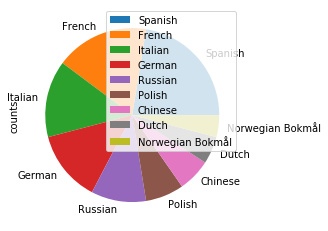

In [14]:
view = instance.get_views(name="talliesTime")[0]
view.start_data_fetch()
tally_pie(view, tally_field='language')

##  Tally users
Show the users who have submitted the most events in the last 200 events. 

In [15]:
@catchInterrupt
def tally_table(view=None, tally_field="title", count=10):
    """Display a title data in a table
    Args:
        view: Streams view that data will be fetched from
        tally_field: fields within view to get data.
        count: number of times to fetch data, < 0 until interrupt 
 
    """
    while (count != 0):
        count = count - 1
        tallies = view.fetch_tuples(max_tuples=100, timeout=2)
        if tallies is not None and len(tallies) != 0:
            title_tallies = tallies[0][tally_field]
            title = [ele[0] for ele in title_tallies]
            cnt = [ele[1] for ele in title_tallies]
            tbl = [(tally_field, title),('count', cnt)]
            df = pd.DataFrame.from_items(tbl)
            display(df)
            clear_output(wait=True)
        else:
            display("Fetch Fail")

In [16]:
view = instance.get_views(name="talliesCount")[0]
view.start_data_fetch()
tally_table(view, tally_field="user")

,user,count
0,Andrew J.Kurbiko,8
1,Sebastian Wallroth,8
2,Dominic,7
3,Up and Go,6
4,Simon Villeneuve,3
5,Infovarius,2
6,DeoxysX,1
7,Berdea,1
8,Ruwaym,1
9,WikipSQ,1


## Tally titles
Show the most updated titles within the last 200 events. 

In [17]:
view = instance.get_views(name="talliesCount")[0]
view.start_data_fetch()
tally_table(view, tally_field="title")

,title,count
0,Q66339698,4
1,Q63898425,3
2,Q28071845,2
3,Q67131024,2
4,Angela Ardinghelli,2
5,Q61106568,2
6,Q63357613,2
7,"File:Bundesarchiv Bild 141-2738, Unterirdische...",1
8,"File:Bundesarchiv Bild 141-2716, Britisches Fl...",1
9,Josephine Langford,1


## Cancel jobs when your done

In [18]:
list_jobs(instance, cancel=True)

# Notebook wrap up. 

This notebook composed and deployed a Streams application that processes live Wikipedia events on a server. We 
mapped definition and created windows of were aggreagated and pushed out to views where they are rendered. 

This being a demonstration the windows are contrained. Letting the application run for longer 
periods and expanding the windows may provide insights. The code in the vicinity of 'window(count)' and 'window(time)' is where window size is manipulated. 

Since Streams application is running on server, it is not necessary to notebook open. Close the notebook and executing
the cells up to 'List jobs and cancel....' will restablish a connection views. Accessing extended views 
will show active trends. 

In the next notebook we will continue to build out the notebook, by rendering images as they are subitted to Wikipedia.



# Appendix 

## Two tables and a graph.....

The goal of this code is to illustrate a dashboard within a notebook realtime rendering Wikipedia activity. 
This spawns three threads that independently fetchs views and renders them using widgets. 
Due to the inconsistencies of among browsers, hardware and data connection I've moved this to an appendix.

In [19]:
def tally_out(*args, out=None, tally_field='title'):
    """
    Render tally data: json format of order list of lists. 
```    
{'language': [['English', 1178],
   ['French', 39],
   ['German', 38],
   ['Spanish', 38],
   ['Italian', 32],
   ['Portuguese', 28],
   ['Russian', 27],
   ['Swedish', 13],
   ['Dutch', 11],
   ['Hebrew', 10]]}]
```
    """
    tallies = args[0]
    assert tally_field in tallies[0], "Field {} does not exist in input tuples, keys found : {}".format(tally_field, tallies[0].keys()) 
    title_tallies = tallies[0][tally_field]
    title = [ele[0] for ele in title_tallies]
    count = [ele[1] for ele in title_tallies]
    tbl = [(tally_field, title),('count', count)]
    out.append_display_data(pd.DataFrame.from_dict(dict(tbl)))
    out.clear_output(wait=True)

def default_out(*args, out=None):
    tuples = args[0]
    out.append_display_data(pd.DataFrame(tuples))
    out.clear_output(wait=True)

def pie_out(*args, out=None, tally_field="language", drop_top=True):
    """Render piechart into Output
    drop_top: do not display the highest value element. 
    
    """
    tuples = args[0]
    if drop_top:
        start = -1
    else:
        start = 0
    assert tally_field in tuples[0], "Field {} does not exist in input tuples, keys found : {}".format(tally_field, tuples[0].keys()) 
    language= [lst[0] for lst in tuples[start][tally_field]]
    counts = [lst[-1] for lst in tuples[start][tally_field]]
    percent = counts[0]/sum(counts) * 100
    #print("[{2}]{0:4.2f}% of the events are in {1},\n {1} will be dropped from the piechart.".format(percent,language[0],"+*"[idx%2]))
    df = pd.DataFrame({'counts': counts[1:]}, index=language[1:])
    with out:
        plt.show(df.plot.pie(y='counts'))
        clear_output(wait=True) 

In [20]:
def graph_display_out(self, duration, period, active, label, lock, transform_func):
    """
    """
    import pandas as pd
    import IPython
    tqueue = self.start_data_fetch()
    end = time.time() + float(duration) if duration is not None else None
    max_rows = pd.options.display.max_rows
    max_rows = 10
    last = 0
    idx = 0
    try:
        while self._data_fetcher and (duration is None or time.time() < end):
            idx += 1
            # Slow down pace when view is busy
            gap = time.time() - last
            label.value = "{0} wait:{1:4.2}".format("-|"[idx%2],period - gap)
            if gap < period:
                time.sleep(period - gap)
            # Display latest tuples by removing earlier ones
            # Avoids display falling behind live data with
            # large view buffer
            tqs = tqueue.qsize()
            if tqs > max_rows:
                tqs -= max_rows
                for _ in range(tqs):
                    try:
                        tqueue.get(block=False)
                    except queue.Empty:
                        break
            tuples = self.fetch_tuples(max_rows, None)
            if not tuples:
                if not self._data_fetcher:
                    break
                #out.append_stdout('No tuples')
            else:
                lock.acquire()
                transform_func(tuples) ### make call to modfield tally_test
                #out.clear_output(wait=True)
                lock.release()
                #out.append_display_data(pd.DataFrame(tuples))
            #out.clear_output(wait=True)
            last = time.time()
    except Exception as e:
        self.stop_data_fetch()
        label.value = str(e)
        active.value=False
        raise e
    label.value = "-"
    self.stop_data_fetch()
    active.value=False

In [21]:
try:
    view_talliesUser.stop_data_fetch()
except NameError as e:
    print ("Views not defined.", e)

try:
    view_talliesTitle.stop_data_fetch()
except NameError as e:
    print ("Views not defined.", e)
    
try:
    view_talliesLanguage.stop_data_fetch()
except NameError as e:
    print ("Views not defined.", e)

view_talliesUser = instance.get_views(name="talliesCount")[0]
print(view_talliesUser.start_data_fetch())
view_talliesTitle = instance.get_views(name="talliesCount")[0]
print(view_talliesTitle.start_data_fetch())
view_talliesLanguage  = instance.get_views(name="talliesTime")[0]
print(view_talliesLanguage.start_data_fetch())

Views not defined. name 'view_talliesUser' is not defined
Views not defined. name 'view_talliesTitle' is not defined
Views not defined. name 'view_talliesLanguage' is not defined


In [22]:
import ipywidgets as widgets
import threading
from  functools import partial
import time

lock = threading.Lock()

self1 = view_talliesUser
self2 = view_talliesTitle
self3 = view_talliesLanguage

duration = 60.0
period = 2.0

topline = widgets.Text(value=self1.description, description="Testing", disabled=True)
active1 = widgets.Valid(value=True, description='users', readout='Stopped')
label1 = widgets.Label(value="starting", description="status")
active2 = widgets.Valid(value=True, description='titles', readout='Stopped')
label2 = widgets.Label(value="starting")
active3 = widgets.Valid(value=True, description='languages', readout='Stopped')
label3 = widgets.Label(value="starting")
user_region = widgets.Output(layout={'border': '1px solid red','width':'30%','height':'270pt'})
title_region = widgets.Output(layout={'border': '1px solid black','width':'30%','height':'270pt'})
chart_region = widgets.Output(layout={'border': '3px solid orange','width':'60%', "height":"270pt"})
user_region.clear_output(wait=True)
title_region.clear_output(wait=True)
chart_region.clear_output(wait=True)
status = widgets.HBox([topline])
activity = widgets.HBox([active1, label1, active2, label2, active3, label3])
tables = widgets.HBox([user_region,title_region])
piechart = widgets.HBox([chart_region])
dashboard = widgets.VBox([status, activity, tables, piechart])
display(dashboard)

self1._display_thread = threading.Thread(target=lambda: graph_display_out(self1, duration, period, active1, label1, lock, partial(tally_out, tally_field="user", out=user_region) ))
self2._display_thread = threading.Thread(target=lambda: graph_display_out(self2, duration, period, active2, label2, lock, partial(tally_out, tally_field="title", out=title_region)))
self3._display_thread = threading.Thread(target=lambda: graph_display_out(self3, duration, period, active3, label3, lock, partial(pie_out, out=chart_region)))

self1._display_thread.start()
self2._display_thread.start()
self3._display_thread.start()